## Implementacja Regresji Liniowej

### Importy

In [0]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

### Regresja Liniowa
Regresja Liniowa to jeden z najprostszych modeli Uczenia Maszynowego. Służy do estymowania wartości przy pomocy liniowej funkcji **f** (np. ceny mieszkania na bazie jego parametrów, wartości akcji na giełdzie, temperatura w danym dniu, ilośc rowerów na stanie w wyporzyczalni).

Zalicza się do algorythmów z rodziny Uczenia Nadzorowanego. Oznacza to, że potrzebny jest zbiór danych uczących - par sładających się z wektórów danych wejściowych zapisanych w macierzy **X** oraz oczekiwanych rezultatów dla każego takiego wektora, zapisanych w wektorze **y**. Każdy wiersz macierzy **X** to odzielny przykład i ma do siebie przypisaną wartość docelową, na takiej samej pozycji, ale w wektorze **y**.

![img_data_structure](https://i.imgur.com/PK9IPgk.png)


Regresją Liniową możemy nazwać:

- Szereg chronologicznie ułożonych kroków, które mają na celu nastawienie parametrów funkcji matematycznej **f(x)**:

  $$f(x) = w_0 x_0 + w_1 x_1 + ... + w_n x_n + b$$
  
  gdzie:
  - $x$ - wektor danych dla których chcemy dokonać predykcji,
  - $n$ - ilość cech, którymi opisane są nasze,
  - $w$ - waga przypisana do każdej cechy w wektorze x, parametr modelu, który chcemy trenować,
  - $b$ - bias, parametr modelu, który chcemy trenować,

  tak aby wartości zwracane przez funkcję **f** dla każdego wiersza **x** były jak najbliższe wartościom docelowym odpowiedniej wartości w wektorze **y** dla danego wiersza.
  
- Nauczony model przy użyciu algorytmu Regresji Liniowej.

### Kolejne etapy

1. Wczytanie danych macierzy danych X oraz wektora wartości docelowych y
2. Przgotowanie danych 
3. Stworzenie funkcji, która zainicializuje parametry modelu
4. Stworzenie funkcji, która wykorzystuje aktualne parametry modelu do doknania predykcji
5. Stworzenie funkcji liczącej błąd modelu
6. Stworzenie funkcji aktualizującej parametry modelu
7. Zestawienie całości w klasę

### Postawmy sobie problem

**Chcemy kupić mieszkanie w Krakowie o wielkości 83$m^2$**. **Za ile tysięcy złotych powinniśmy kupić to mieszkanie aby nie przepłacić? **

Aby rozwiązać ten problem, można wejść na wiele stron internetowych gdzie ogłaszane są oferty mieszkań i spisać oferty, w tym ile kosztuje mieszkanie (jako wartość docelowa) oraz parametry mieszkania - np. rozmiar, kiedy zostanie wybudowane, położenie, odległość od centrum, odległość od supermarketu, szkoły etc...

Do tego ćwiczenia wykorzystamy zbiór danych, który sam przygotowałem, dokładnie w taki sposób, w celach edukacyjnych. W tym wypadku mamy do dyspozycji tylko rozmiar mieszkania dla uproszczenia problemu.

## Krok 1: Wczytanie danych


Rozmiar macierzy X: (36, 1)
Rozmiar wektora y: (36,)


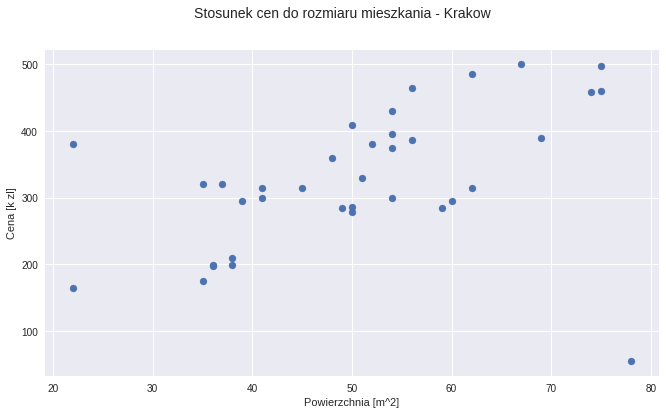

In [3]:
# Rozmiar mieszkań w m^2
X = np.array([[22.], [22.], [35.], [35.], [36.], [36.], [37.], [38.], [38.], 
              [39.], [41.], [41.], [45.], [48.], [49.], [50.], [50.], [50.], 
              [51.], [52.], [54.], [54.], [54.], [54.], [56.], [56.], [59.],
              [60.], [62.], [62.], [67.], [69.], [74.], [75.], [75.], [78.]])
    
# Ceny mieszkania w tysiącach zł
y = np.array([164., 380., 175., 320., 199., 198., 320., 210., 199., 295., 315.,
              299., 315., 359., 285., 279., 409., 286., 330., 380., 375., 396., 
              430., 299., 387., 465., 285., 295., 485., 314., 500., 390., 459., 
              498., 460., 55. ])

# Rozmiar zbiorów danych
print("Rozmiar macierzy X: {}".format(X.shape))
print("Rozmiar wektora y: {}".format(y.shape))

# Wizualizacja danych
fig = plt.figure(figsize=(11,6))
fig.suptitle("Stosunek cen do rozmiaru mieszkania - Krakow", fontsize=14)
plt.scatter(X[:,0], y);
plt.ylabel('Cena [k zl]')
plt.xlabel('Powierzchnia [m^2]');

### Krok 2: Przygotowanie danych
Jedną z podstawowych czynności dokonywanych na danych, zanim wrzucimy je do algorytmu, jest normalizacja. Więcej na:

https://en.wikipedia.org/wiki/Feature_scaling

Celem normalizacji jest sprawienie by nasze dane miały mały zakres wartości. Najczęsciej sprowadzamy je do przedziału [0, 1]. Nie wdając się w matematyczne szczegóły dlaczego normalizacja jest dobra, zapamiętajmy:

- normalizacja przyśpiesza działanie niektórych algorytmów uczenia maszynowego
- normalizacja pozwala na spłaszczenie wartości danych przy nie zaburzaniu proporcji pomiędzy nimi
- dzięki normalizacji unikamy operacji na bardzo dużych liczbach, porównywania dużych liczb do bardzo małych (w przypadku liczeniu dystansów pomiędzy parametrami)

Jak to działa?

$$x_{norm} = \frac{x - min(x)}{max(x) - min(x)}$$

gdzie:
- x - to cecha ilościowa np. powierzchnia domu, wzrost, wiek etc.


In [0]:
def get_feature_info(X):
  """Funkcja, która zbiera max i min wartości z każdej cechy.
  Parametry:
    X - dane wszystkich mieszkań dla których ma być dokonana predykcja
  """
  num_features = X.shape[1]
  
  norm_info = dict()
  for i in range(num_features):
    feature_max = np.max(X[:, i])
    feature_min= np.min(X[:, i])
    norm_info[i] = {"max": feature_max, "min": feature_min}

  return norm_info

In [0]:
def normalize(X, norm_info):
  """Funkcja, która skaluje wartości każdej cechy w macierzy X do przedziału
  wartości [0, 1].
  Parametry:
    X - dane wszystkich mieszkań dla których ma być dokonana predykcja
    norm_info - dictionary przechowujące zasięgi cech"""
  num_features = X.shape[1]
  
  X_norm = X.copy()
  for i in range(num_features):
    f_min = norm_info[i]["min"]
    f_max = norm_info[i]["max"]
    X_norm[:, i] = (X[:, i] - f_min) / (f_max - f_min)
    
  return X_norm

In [6]:
# Pobranie informacji o zasięgach cech
norm_info = get_feature_info(X)

# Normalizacjia
X_norm = normalize(X, norm_info)

# Rezultat
print(X_norm)

[[0.        ]
 [0.        ]
 [0.23214286]
 [0.23214286]
 [0.25      ]
 [0.25      ]
 [0.26785714]
 [0.28571429]
 [0.28571429]
 [0.30357143]
 [0.33928571]
 [0.33928571]
 [0.41071429]
 [0.46428571]
 [0.48214286]
 [0.5       ]
 [0.5       ]
 [0.5       ]
 [0.51785714]
 [0.53571429]
 [0.57142857]
 [0.57142857]
 [0.57142857]
 [0.57142857]
 [0.60714286]
 [0.60714286]
 [0.66071429]
 [0.67857143]
 [0.71428571]
 [0.71428571]
 [0.80357143]
 [0.83928571]
 [0.92857143]
 [0.94642857]
 [0.94642857]
 [1.        ]]


### Krok 3: Inicjalizacja parametrów modelu

In [0]:
def init(n):
  """Funkcja, która inicjalizuje wartości wag oraz bias. Parametry przechowywane 
  są w formie dictionary. Wagi są wektorem o rozmiarze (n,) a bias to pojedyńcza
  liczba.
  Parametry:
    n - ilość cech w każdym wierszu macierzy X
  """
  
  parameters = dict()
  parameters["w"] = np.zeros(n)
  parameters["b"] = 0
  
  return parameters
  

In [8]:
# Ilośc cech w wierszu macierzy X
n = X.shape[1]

# Zainicjalizowane parametery modelu
parameters = init(n)
print(parameters)

{'b': 0, 'w': array([0.])}


### Krok 4: Dokonanie predykcji przy aktualnych parametrach modelu
Predykcji wartości dokonuje się przy pomocy funkcji **f**. Dla naszego przypadku funkcja ta wygląda następująco:

$$f(x) = w_0 x_0 + b$$
  
Wynika to z tego, że posiadamy tylko jedną cechę opisującą mieszkanie jaką jest **powierzchnia**. Tak więc każda **powierzchnia** mieszkania będzie przemnażana przez jakąś (początkowo zainicializowaną na 0) wagę i będzie dodany bias.


In [0]:
def predict(x, parameters):
  """Funkcja, która dla cech jednego mieszkania dokonuje predykcji na bazie
  aktualnych parametrów mieszkania.
  Parametry:
    x - wektor z cechami mieszkania
    parameters - dictionary z aktualnymi parametrami modelu
  """
 ź
  
  return result

In [10]:
# Cechy pierwszego mieszkania
powierzchnia0 = X[0]
cena0 = y[0]

# Predykcja
pred = predict(powierzchnia0, parameters)
print("Przewidziana cena: {} [k zł]".format(pred))
print("Oczekiwana cena: {} [k zł]".format(cena0))


Przewidziana cena: 0.0 [k zł]
Oczekiwana cena: 164.0 [k zł]


Ponieważ parametry modelu są zerami, nie dziwnym jest, że będzie dla każdej powierzchni mieszkania przewidywał wartośc 0. Ale o nastawieniu parametrów modelu za chwile a teraz przyjżyjmy się jeszcze na chwilę funkcji `predict`. 

Zamiast pisać niewygodną `pętlę for` za każdym razem kiedy chcemy skorzystać z modelu, możemy sprawić by funkcja `predict` nie brała tylko wektora (cech jednego mieszkania) jako swój parametr wejściowy funkcji, ale całą macierz i zwróciła wektor predykcji dla każdego wiersza:

In [0]:
def predict(X, parameters):
  """Funkcja, która dla cech wielu mieszkań dokonuje predykcji na bazie
  aktualnych parametrów modelu.
  Parametry:
    X - dane wszystkich mieszkań dla których ma być dokonana predykcja
    parameters - dictionary z aktualnymi parametrami modelu
  """
  predictions = list()
  
  for features in X:
    result = 0

    for feature, weight in zip(features, parameters["w"]):
        result += feature * weight

    result += parameters["b"] 
    predictions.append(result)
  
  return np.array(predictions)

In [12]:
pred = predict(X, parameters)
print("Przewidywana cena dla każdego mieszkania zawartego w macierzy X: \n{}".format(pred))

Przewidywana cena dla każdego mieszkania zawartego w macierzy X: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Pozostaje jeszcze jedna kwestia. Takie dokonywanie predykcji, przy użyciu trzech `pętli for` jest nie efektywne. Jeżeli mielibyśmy dane milionów mieszkań w macierzy **X** i opisywalibyśmy każde przy użyciu wielu cech, to taki kod byłby bardzo powolny. W tym problemie może pomóc znajomość matematyki, a dokładniej coś co nazywa się **wektoryzacją**.

Taki sam rezultat jestesmy w stanie uzyskać, jeżeli pomnożymy macierz danych **X** przez wektor wag **w** i dodamy bias **b**:

$$ f(X) = Xw + b = 
    \begin{bmatrix}
    x_{00} & x_{01} & \dots  & x_{0n} \\
    x_{10} & x_{11} & \dots  & x_{1n} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{m0} & x_{m1} & \dots  & x_{mn}
    \end{bmatrix} 
    \begin{bmatrix}
    w_0 \\
    w_1 \\
    \vdots \\
    w_n 
    \end{bmatrix} + b = 
    \begin{bmatrix}
    w_0x_{00} + w_1x_{01} + w_nx_{0n} + b \\
    w_0x_{10} + w_1x_{11} + w_nx_{1n} + b \\
    \vdots \\
    w_0x_{m0} + w_1x_{m1} + w_nx_{mn} + b 
    \end{bmatrix} $$
   
gdzie:
- $m$ - ilość przykładów w zbiorze uczącym
- $n$ - ilość cech w każdym przykładzie
- $X$ - macierz przechowująca dane przykładów o rozmiarze (m,n)
- $w$ - wektor wag o rozmiarze (n,)
- $b$ - bias

In [0]:
def predict(X, parameters):
  """Funkcja, która dla cech wielu mieszkań dokonuje predykcji na bazie
  aktualnych parametrów mieszkania.
  Parametry:
    X - dane wszystkich mieszkań dla których ma być dokonana predykcja
    parameters - dictionary z aktualnymi parametrami modelu
  """  
  return np.dot(X, parameters["w"]) + parameters["b"]

In [14]:
pred = predict(X, parameters)
print("Przewidywana cena dla każdego mieszkania zawartego w macierzy X: \n{}".format(pred))

Przewidywana cena dla każdego mieszkania zawartego w macierzy X: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Jedna linijka kodu, ten sam rezultat! Wektoryzacja jest bardzo ważnym tematem wykrzystywanym w algorytmach Uczenia Maszynowego bardzo często. Całe Sieci Neuronowe opierają się na wektoryzacji.

--------------------
Dodatkowo dochodzi aspekt obliczeniowy. Jak już mówiłem, część algorytmów wymaga normalizacji (albo standaryzacji). Regresja Liniowa jest takim algorytmem, dlatego chcielibyśmy być pewni, że dane są znormalizowane, zanim dokonujemy obliczeń. Stąd przepiszemy `predict` tak by dodatkowo normalizował dane, przed wykonaniem predykcji.

In [0]:
def predict(X, parameters, norm_info):
  """Funkcja, która dla cech wielu mieszkań dokonuje predykcji na bazie
  aktualnych parametrów mieszkania.
  Parametry:
    X - dane wszystkich mieszkań dla których ma być dokonana predykcja
    parameters - dictionary z aktualnymi parametrami modelu
    norm_info - dictionary przechowujące zasięgi cech
  """  
  # Normalizacja
  X_norm = normalize(X, norm_info)
  
  #Predykcja
  predictions = np.dot(X_norm, parameters["w"]) + parameters["b"]
  
  return predictions

### Krok 5: Stworzenie funkcji liczącej błąd modelu
Jak wspomniane było na początu, Regresja Liniowa próbuje dokonać predykcji wartości na bazie dopasowania funkcji liniowej do danych. Ponieważ mamy już parametry modelu i wiemy jaką funkcję model aproksymuje to możemy ją narysować:


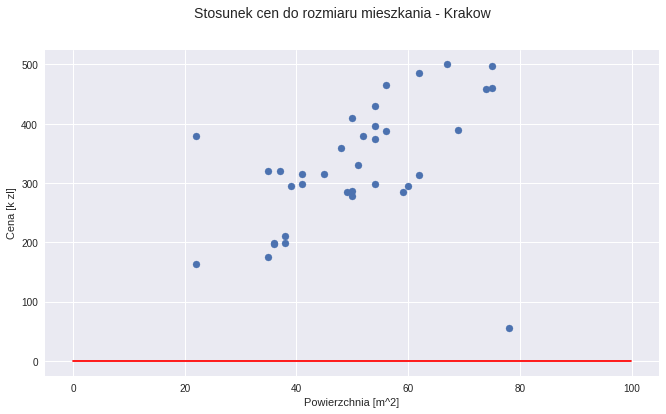

In [16]:
# Wizualizacja danych
fig = plt.figure(figsize=(11,6))
fig.suptitle("Stosunek cen do rozmiaru mieszkania - Krakow", fontsize=14)
plt.scatter(X[:,0], y);
plt.ylabel('Cena [k zl]')
plt.xlabel('Powierzchnia [m^2]');

value_space = np.arange(0, 100, 0.1).reshape(-1, 1)
predictions = predict(value_space, parameters, norm_info)

plt.plot(np.arange(0, 100, 0.1), predictions, c="red");

Z wykresu widać, że nie ważne jaka powierzchnia - zawsze przewidujemy zero. Ale **odległość czerwonej prostej od każdego z punktów na wykresie jest różna**. Ujmując to inaczej w niektórych przypadkach pomyliliśmy się o paredziesiąt tysięcy a w innych o pareset. 

Moglibyśmy więc zsumować odległość każdego z punktów od czerwonej prostej (jako wartość bezwzględną) i podzielić przez ilość punktów by uzyskać średni błąd. Taka definicja błędu nazywa się MAE (Mean Average Error) i więcej można o niej przeczytać tutaj:

https://en.wikipedia.org/wiki/Mean_absolute_error

Definicji błędów jest wiele i każda dostarcza innych właściwości. Najlpopularniejszą funkcją kosztu wykorzystywaną w problemie regresji jest MSE (Mean Square Error), który różni się od MAE jedynie tym, że zamiast wartości bezwględnej podnosimy odległości od punktów do kwadratu. To nadaje ciekawą właściwość - naliczamy większy błąd za duże pomyłki i mniejszy błąd za mniejsze pomyłki. Wzór MSE prezentuje się następująco:

$$ J(X, y) = \frac{1}{m}\sum_{i=1}^m(f(x^{(i)}) - y^{(i)})^2 $$

gdzie:
- $X$ - macierz ze wszystkimi danymi do uczenia
- $y$ - macierz z wartościami docelowymi
- $m$ - ilość przykładów w zbiorze uczącym (punktów na wykresie)
- $i$ - indeks przykładu w sumie ($\sum_{i=1}^m$ oznacza sumę, działa jak pętla `for`, która iteruje po każdym przykładzie `i` z tablicy o wielkości `m`)
- $f$ - funkcja, która dokonuje predykcji
- $x_i$ - i-ty wiersz macierzy $X$
- $y_i$ - i-ta wartość wektora $y$

Warto wspomnieć, że wartość tego błędu nigdy nie może przyjmować wartości ujemnej. Na pewno łatwiej będzie to wszystko zrozumieć po tym jak zamienimy ten wzór matematyczny w kod:


In [0]:
def calculate_error(predictions, y):
  """Funkcja, która oblicza różnice pomiędzy predykcjami zwróconymi przez model 
  a wartościami docelowymi (oczekiwanymi). Różnice te są podniesiona do 
  kwadratu i zsumowane. Całość jest podzielona przez ilość przykładów użytych
  do predykcji. Rezultatem jest średni błąd modelu przypadający na każdą 
  predykcję.
  Parametry:
    predictions - predykcje modelu, produkt wrzucenia macierzy X do funkcji f
    y - wektor wartości docelowych
  """
  # Ilość przykładów użytych do predykcji
  m = predictions.shape[0]
  
  # Suma wszystkich błędów
  error = 0
  for prediction, target in zip(predictions, y):
    difference = prediction - target
    difference_squared = np.power(difference, 2)
    error += difference_squared
    
  # Uśredniony błąd
  error /= m
  return error
    

In [18]:
mse_error = calculate_error(pred, y)
print("Aktualny błąd modelu: {}".format(mse_error))

Aktualny błąd modelu: 118045.666667


Ponownie możemy pozbyć się `pętli for` poprzez zastosowanie wektoryzacji. Rezultatem $f(X)$ jest wektor predykcji, $y$ jest również wektorem wartości docelowych. Tak więc możemy je od siebie odjąc by uzyskać wektor różnic wyników dla każdego przykładu. 

In [0]:
def calculate_error_vec(predictions, y):
  """Funkcja, która oblicza różnice pomiędzy predykcjami zwróconymi przez model 
  a wartościami docelowymi (oczekiwanymi). Różnice te są podniesiona do 
  kwadratu i zsumowane. Całość jest podzielona przez ilość przykładów użytych
  do predykcji. Rezultatem jest średni błąd modelu przypadający na każdą 
  predykcję.
  Parametry:
    predictions - predykcje modelu, produkt wrzucenia macierzy X do funkcji f
    y - wektor wartości docelowych
  """
  return np.sum(np.power(predictions - y, 2)) / predictions.shape[0]
    

In [20]:
mse_error = calculate_error_vec(pred, y)
print("Aktualny błąd modelu: {}".format(mse_error))

Aktualny błąd modelu: 118045.666667


Taki sam wynik a dużo mniej kodu i zysk na prędkości. Błąd to bardzo duża liczba, gdyż nasz model zrobił poważne pomyłki. 

### Krok 6: Stworzenie funkcji aktualizującej parametry modelu

Po co nam właściwie jest funkcja obliczająca średni błąd modelu? Otóż jest przydatna do tego by informować nas w jaki sposób mamy zmieniać parametry modelu czyli **wagi** oraz **bias**. Czysto intuicyjnie:

In [21]:
# Wymyślone z głowy parametry 1
porponowane_parametry_1 = {"b": 0, "w": np.array([150.])}
pred_1 = predict(X, porponowane_parametry_1, norm_info)
mse_error_1 = calculate_error_vec(pred_1, y)
print("Błąd dla predykcji uzyskanych przy użyciu parametrów zestawu 1: {}"
      .format(mse_error_1))

# Wymyślone z głowy parametry 2
porponowane_parametry_2 = {"b": 0, "w": np.array([-150.])}
pred_2 = predict(X, porponowane_parametry_2, norm_info)
mse_error_2 = calculate_error_vec(pred_2, y)
print("Błąd dla predykcji uzyskanych przy użyciu parametrów zestawu 2: {}"
      .format(mse_error_2))

Błąd dla predykcji uzyskanych przy użyciu parametrów zestawu 1: 71508.9053997
Błąd dla predykcji uzyskanych przy użyciu parametrów zestawu 2: 179178.250638


Już z podając losowe parametry, możemy stwierdzić, że `zestaw parametrów 1` jest lepszy niż `zestaw parametrów 2`. W teori moglibyśmy losować wartości parametrów po pareset tysięcy razy i zapisywać najlepszy wynik, ale to bardzo nieefektywne obliczeniowo.

### Uczenie "na siłę"
Ten przykład ma na zadaniu dostarczenie intuicji związanej z nastawianiem parametrów modelu. Załóżmy, że próbujemy uzyskać najlepszy wynik nastawiając tylko wagę **w**. Czyli bias **b** będzie **zawsze 0**.

W iteracjach modyfikujmy wagę **w** o małą wartość **step**. Początkowo dodajmy **step** do wagi **w**, dokonajmy predykcji i policzmy błąd. Jeżeli się zwiększył to znaczy, że musimy odjąć **step**. Róbmy to tak długo, aż nasz błąd przestanie się zmieniać:

In [0]:
def brute_force_learning(X, y, step=0.1, iterations=7000):
  # Wartości pomocnicze
  negative_direction = -1
  positive_direction = 1
  
  # Rozmiar danych
  m, n = X.shape
  
  # Inicjalizacja parametrów
  parameters = init(n)
  
  # Pierwsza predykcja i błąd wyjściowy
  pred = predict(X, parameters, norm_info)
  error = calculate_error_vec(pred, y)
  
  # Uczenie
  current_error = error
  for i in range(iterations):
    
    # Próba dodania wartości
    new_parameters_candidate = parameters.copy()
    new_parameters_candidate["w"] += positive_direction * step
    candidate_pred = predict(X, new_parameters_candidate, norm_info)
    candidate_error = calculate_error_vec(candidate_pred, y)
   
    if candidate_error < current_error:
      # Wagi zmodyfikowane w dobrym kierunku, zmieńmy parametry
      parameters = new_parameters_candidate
      current_error = candidate_error
    else: 
      # Dodanie wartości nie pomogło, zmieńmy w drugim kierunku
      new_parameters_candidate = parameters.copy()
      new_parameters_candidate["w"] += negative_direction * step
      candidate_pred = predict(X, new_parameters_candidate, norm_info)
      candidate_error = calculate_error_vec(candidate_pred, y)
      
      if candidate_error < current_error:
        parameters = new_parameters_candidate
        current_error = candidate_error
      
    # Wyświetlanie rezultatów uczenia
    if i % 500 == 0:
      print("Error at iteration {}: {}".format(i, current_error))
  
  return parameters

In [23]:
brute_parameters = brute_force_learning(X, y)

Error at iteration 0: 118009.780128
Error at iteration 500: 100879.011811
Error at iteration 1000: 85370.0015712
Error at iteration 1500: 71482.7494099
Error at iteration 2000: 59217.2553269
Error at iteration 2500: 48573.519322
Error at iteration 3000: 39551.5413954
Error at iteration 3500: 32151.3215471
Error at iteration 4000: 26372.859777
Error at iteration 4500: 22216.1560851
Error at iteration 5000: 19681.2104714
Error at iteration 5500: 18768.022936
Error at iteration 6000: 18764.7965528
Error at iteration 6500: 18764.7965528


Parametry modelu po uczeniu: {'b': 0, 'w': array([553.3])}


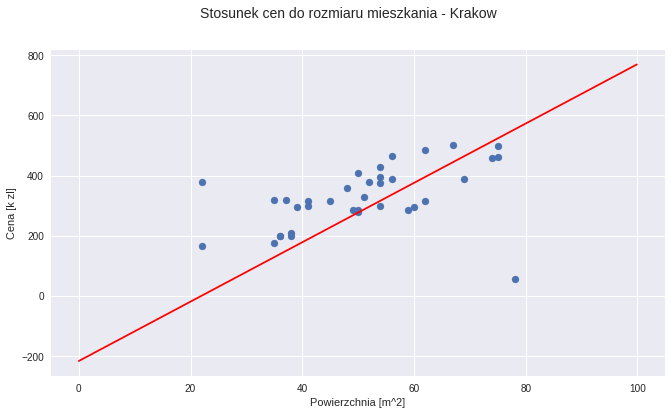

In [24]:
print("Parametry modelu po uczeniu: {}".format(brute_parameters))

# Wizualizacja danych
fig = plt.figure(figsize=(11,6))
fig.suptitle("Stosunek cen do rozmiaru mieszkania - Krakow", fontsize=14)
plt.scatter(X[:,0], y);
plt.ylabel('Cena [k zl]')
plt.xlabel('Powierzchnia [m^2]');

value_space = np.arange(0, 100, 0.1).reshape(-1, 1)
predictions = predict(value_space, brute_parameters, norm_info)

plt.plot(np.arange(0, 100, 0.1), predictions, c="red");

#### Spadek Gradientu
W poprzednim rozwiązaniu mieliśmy dwa problemy:
- nie wiedzieliśmy w którym kierunku powinniśmy modyfikować nasz parametr, dlatego próbowaliśmy go zmieniać w jedną stronę a jak nie wyszło to w drugą
- wartość o jaką zmienialiśmy parametr była wpisana na sztywno - w zależnośći od problemu mogłoby to prowadzić do niemożności otrzymania lepszego wyniku

W tym wszystkim możemy dodać jeszcze to, że jeżeli mielibyśmy do nauczenia dwa parametry zamiast jednego to musielibysmy wybrać najlepszą kombinację z opcji:
- zwiększy parametr 1, zwiększy parametr 2
- zmniejsz parametr 1, zmniejsz parametr 2
- zwiększ parametr 1, zmniejsz parametr 2
- zmniejsz parametr 1, zwiększ parametr 2
- nie zmieniaj parametru 1, zwiększ parametr 2
- nie zmieniaj parametru 1, zmniejsz parametr 2
- zwiększ parametr 1, nie zmieniaj parametru 2
- zmniejsz parametr 1, nie zmieniaj parametru 2
- nie zmieniaj parametru 1, nie zmieniaj parametru 2

Trochę tego dużo. Tracimy też bardzo dużo czasu obliczeniowego. A co jakby parametrów było więcej? Na przykład 1000... No ta metoda napewno by nie przeszła. Ale daje informacje co musimy poprawić by było dobrze.

--------------
Tak więc Spadek Gradientu - algorytm, który wykorzystuje właściwości matematyczne **pochodnej** do tego by sukcesywnie modyfikować parametry modelu, tak by minimalizować funkcję kosztu.


Intuicja na temat pochodnej:

Wyobraź sobie, że ze ściany wystają dwa pręty, pręt A oraz pręt B. Ktoś każe Ci zbadać zależność pomiędzy nimi. Pręt A ma długość 0.5m, pręt B ma długość 1m. Podchodzisz więc do ściany i dociskasz pręt A. Widzisz, że długość prętu B rośnie dwukrotnie w porównaniu do chowanej się długości prętu A. Wyciągasz więc pręt A i widzisz jak długosć prętu B maleje. Obserwujemy więc:
$$ b = 2*a $$

To `2` w tym wzorze oznacza **pochodną**. Czyli jest to wartość, która opisuje zależność pomiędzy dwoma parametrami we wzorze matematycznym. Albo inaczej, jak modyfikacja parametru `a` wpływa na patametr `b`.

Czyli tak naprawdę, jeżeli policzylibyśmy **pochodną** dla każdej wagi i biasu - w naszym przypadku $\frac{dJ}{dw_0}$ oraz $\frac{dJ}{db}$ bo dla jednej cechy (powierzchni) tylko takie mamy, z:
$$ J(X, y) = \frac{1}{m}\sum_{i=1}^m(f(x^{(i)})) - y^{(i)})^2 $$

To wiedzielibyśmy w jaki sposób zmieniać wartość `w0` i `b` by wpływać odpowiednio na `J`. Z geometrycznej interpretacji pochodnej można powiedzieć, że jeżeli do `w0` lub `b` **dodamy** wartość ich pochodnej to `J` będzie rosnąć, a jeżeli **odejmiemy** to `J` będzie maleć. A tego chcemy - by `J` było jak najmniejsze!

Problem może polegać tylko w tym, że policzenie tej **pochodnej** wymaga 1.5 roku studiów o profilu związanym z matematyką. Z drugiej strony powołując się na wiele ciekawych osób takich jak:
- **Andrew Trask**: Pracownik zespołu Google Brain i doktorant na Oxfordzie - napisał książkę, w której pozakzał jak tworzyć nawet bardzo skomplikowane sieci neuronowe bez użycia matematyki (ani jednego wzoru). Ta analogia, którą podaje tutaj, jest z jego książki "Grokking Deep Learning". Andrew twierdzi, że te wzory dotyczace pochodnych można tak naprawdę **wyczytać z tabelki**.
- **Andrew Ng**: Jedno z najwiekszych nazwisk na świecie w dziedzinie AI. Profesor na uczelni Stanford. Autor legendarnych kursów dot. Machine Learningu i ostatnio Deep Learningu na Courserze. W swoim wywiadzie z Ian Goodfellowem (twórcą GAN-ów, sieci neuronówych generujących obrazy) twierdzi, że AI są w stanie nauczyć się ludzie, których matematyka jest na niskim poziomie.

Sam miałem okazje zrobić wiele kursów z tych tematów i nigdzie nie kazano liczyć tych pochodnych. 

- **Nie ma sensu wynajdować koła od nowa.**
- **Nie musisz wiedzieć jak działa silnik by być kierowcą.**

Dodatkowo pamiętaj, że implementujemy ten algorytm od 0 w celach edukacyjnych. W pracy będziesz używać narzedzi takich jak `sklearn`, `tensorflow`, `keras`, `cntk`, `PyTorch` i inne, gdzie aktualizowanie parametrów jest napisane już za ciebie. Musisz tylko znać ideę jak to działa. Tu chodzi o zrozumienie **jakie znaczenie ma pochodna w algorytmie Spadku Gradientu**.

Jeżeli Cie to ciekawi to możesz spróbować to policzyć sam. Kiedyś do tego dojdziesz, ale pamiętaj, że to nie o to w tym wszystkim chodzi. Tu jest artykuł w którym pokazana jest dodatkowa intuicja oraz to jak tą pochodną policzyć: http://mccormickml.com/2014/03/04/gradient-descent-derivation/


Jako, że funkcja kosztu **MSE (Mean Squared Errors)** jest bardzo często używana, można też z masy innych źródeł poprostu spisać jej gotową pochodną. A jest następująca:

- dla biasu:

$$\frac{dJ}{db} = \frac{2}{m}\sum_{i=1}^m(f(x^{(i)}) - y^{(i)})$$

- dla wag:

$$\frac{dJ}{dw_0} = \frac{2}{m}\sum_{i=1}^m(f(x^{(i)}) - y^{(i)})x_0^i$$

$$\frac{dJ}{dw_1} = \frac{2}{m}\sum_{i=1}^m(f(x^{(i)}) - y^{(i)})x_1^i$$

$$ ... $$

$$\frac{dJ}{dw_n} = \frac{2}{m}\sum_{i=1}^m(f(x^{(i)}) - y^{(i)})x_n^i$$

Mając te pochodne wagi i bias aktualizujemy w nastepujący sposób:

$$w_n= w_n - \alpha\frac{dJ}{dw_n}$$

$$b= b - \alpha\frac{dJ}{db}$$

Gdzie $\alpha$ to parametr nazywany **learning_rate** i mówi on o tym jaką część wartości pochodnej powinniśmy użyć do aktualizacji parametrów. Dlaczego to takie istotne? Jeżeli nasz model miały tylko jeden parametr i narysowalibyśmy jak zmienia się funkcja kosztu `J` od wartości tego parametru to zauważylibyśmy coś takiego:

![gradient](https://i.stack.imgur.com/yk1mk.png)

Czyli:

1. Inicializujemy nasz parametr i trafiamy w losowy punkt paraboli.
2. Wykonując 1 krok uczenia, aktualizujemy nasz parametr i przesuwamy się bliżej lokalnego minimum - miejsca gdzie błąd jest najmniejszy.
3. O ile się przesunąć? O tym decyduje własnie `learning_rate`. Skaluje wartość pochodnej i mówi czy mamy robic duży krok czy mały.

Jak to wpływa na uczenie?

![LearningRate]](https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAA0oAAAAJDUzMTBlMDdjLWM0ZmMtNDJkNS1hODk3LTAzYTllMDUwZmY1OQ.jpg)

A tu wizualizacje dostępne w internecie obrazujące:

a) Poprawny spadek gradientu

![gradient_descent](https://www.cs.toronto.edu/~frossard/post/linear_regression/sgd.gif)

b) Skutek zbyt dużej wartości parametru **learning rate**

![too_big_learning_rate](https://cdn-images-1.medium.com/max/1600/1*MGThTULxtfCu1XirjLS5hQ.gif)

Implementacja w kodzie:

In [0]:
def train(X, y, parameters, learning_rate=0.01, iteration=7000):
  # Rozmiar danych
  m, n = X.shape
  
  # Pierwsza predykcja i błąd wyjściowy
  pred = predict(X, parameters, norm_info)
  error = calculate_error_vec(pred, y)
  
  # Wyświetlenie wstępnego błędu
  current_error = error
  print("Initial error: {}".format(current_error))
  
  # Uczenie
  error_history = list()
  for i in range(iteration):
    # Wektorowa implementacja spadku gradientu
    pred = predict(X, parameters, norm_info)
    dw = (2.0/m) * np.dot(X.T, pred - y)
    db = (2.0/m) * np.sum(pred - y)
    
    # Aktualizowanie wag
    parameters["w"] = parameters["w"] - learning_rate*dw
    
    # Aktualizowanie biasu
    parameters["b"] = parameters["b"] - learning_rate*db
    
    # Predykcja przy użyciu nowych wag i sprawdzenie jak zmienia się błąd
    pred = predict(X, parameters, norm_info)
    current_error = calculate_error_vec(pred, y)
    
    if i % 250 == 0:
      print("Epoch {} error: {}".format(i, current_error))

In [26]:
train(X, y, parameters)

Initial error: 118045.666667
Epoch 0 error: 30845.6057839
Epoch 250 error: 11427.9718507
Epoch 500 error: 9285.82420679
Epoch 750 error: 8609.19637364
Epoch 1000 error: 8395.47383873
Epoch 1250 error: 8327.96653311
Epoch 1500 error: 8306.64338946
Epoch 1750 error: 8299.90817094
Epoch 2000 error: 8297.78075627
Epoch 2250 error: 8297.10878206
Epoch 2500 error: 8296.89652944
Epoch 2750 error: 8296.82948643
Epoch 3000 error: 8296.80830993
Epoch 3250 error: 8296.80162104
Epoch 3500 error: 8296.79950826
Epoch 3750 error: 8296.7988409
Epoch 4000 error: 8296.79863011
Epoch 4250 error: 8296.79856353
Epoch 4500 error: 8296.7985425
Epoch 4750 error: 8296.79853585
Epoch 5000 error: 8296.79853376
Epoch 5250 error: 8296.79853309
Epoch 5500 error: 8296.79853288
Epoch 5750 error: 8296.79853282
Epoch 6000 error: 8296.7985328
Epoch 6250 error: 8296.79853279
Epoch 6500 error: 8296.79853279
Epoch 6750 error: 8296.79853279


Jeżeli porównamy wyniki uczenia metodą `na siłę` z uczeniem metodą `Spadkiem Gradientu` to można zaobserwować, że:
- Najniższy błąd osiągnięty przez metodę `na siłę` to **18764.** i nastąpiło to po **~6000 iteracjach**.
- Najniższy błąd osiągnięty przez metodę `Spadku Gradientu` to **8296.** i nastąpiło to po **~2500 iteracjach**.

A aktualizowalismy dwa parametry, nie jeden.

Parametry modelu po uczeniu: {'b': 233.44140536313904, 'w': array([184.82763729])}


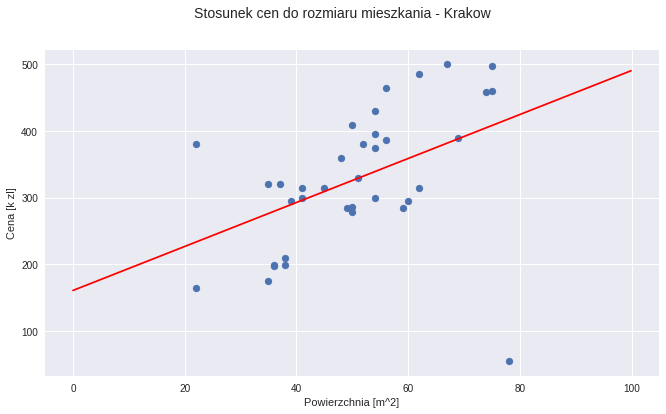

In [27]:
print("Parametry modelu po uczeniu: {}".format(parameters))

# Wizualizacja danych
fig = plt.figure(figsize=(11,6))
fig.suptitle("Stosunek cen do rozmiaru mieszkania - Krakow", fontsize=14)
plt.scatter(X[:,0], y);
plt.ylabel('Cena [k zl]')
plt.xlabel('Powierzchnia [m^2]');

value_space = np.arange(0, 100, 0.1).reshape(-1, 1)
predictions = predict(value_space, parameters, norm_info)

plt.plot(np.arange(0, 100, 0.1), predictions, c="red");

Linia jest po środku punktów. Dużo lepszy rezultat :)

### 7. Zestawienie całości w klase
To wszystko! Dotarliśmy do formalności jaką jest zebranie tych fragmentów kodu jakie napisaliśmy i stworzenie z tego klasy.

In [0]:
class LinearRegression():
  def __init__(self):
      self.parameters = dict()
      self.norm_info = dict()
  
  def get_feature_info(self, X):
    """Funkcja, która zbiera max i min wartości z każdej cechy.
    Parametry:
      X - dane wszystkich mieszkań dla których ma być dokonana predykcja
    """
    num_features = X.shape[1]

    for i in range(num_features):
      feature_max = np.max(X[:, i])
      feature_min= np.min(X[:, i])
      self.norm_info[i] = {"max": feature_max, "min": feature_min}

  def normalize(self, X):
    """Funkcja, która skaluje wartości każdej cechy w macierzy X do przedziału
    wartości [0, 1].
    Parametry:
      X - dane wszystkich mieszkań dla których ma być dokonana predykcja
      norm_info - dictionary przechowujące zasięgi cech"""
    num_features = X.shape[1]

    X_norm = X.copy()
    for i in range(num_features):
      f_min = self.norm_info[i]["min"]
      f_max = self.norm_info[i]["max"]
      X_norm[:, i] = (X[:, i] - f_min) / (f_max - f_min)

    return X_norm
  
  def init(self, n):
    """Funkcja, która inicjalizuje wartości wag oraz bias. Parametry przechowywane 
    są w formie dictionary. Wagi są wektorem o rozmiarze (n,) a bias to pojedyńcza
    liczba.
    Parametry:
      n - ilość cech w każdym wierszu macierzy X
    """  
    self.parameters["w"] = np.zeros(n)
    self.parameters["b"] = 0

  def calculate_error_vec(self, predictions, y):
    """Funkcja, która oblicza różnice pomiędzy predykcjami zwróconymi przez model 
    a wartościami docelowymi (oczekiwanymi). Różnice te są podniesiona do 
    kwadratu i zsumowane. Całość jest podzielona przez ilość przykładów użytych
    do predykcji. Rezultatem jest średni błąd modelu przypadający na każdą 
    predykcję.
    Parametry:
      predictions - predykcje modelu, produkt wrzucenia macierzy X do funkcji f
      y - wektor wartości docelowych
    """
    return np.sum(np.power(predictions - y, 2)) / predictions.shape[0]
  
  def train(self, X, y, learning_rate=0.01, iteration=7000):
    # Rozmiar danych
    m, n = X.shape
    
    # Init Parameters
    self.init(n)
    self.get_feature_info(X)

    # Pierwsza predykcja i błąd wyjściowy
    pred = self.predict(X)
    error = self.calculate_error_vec(pred, y)

    # Wyświetlenie wstępnego błędu
    current_error = error
    print("Initial error: {}".format(current_error))

    # Uczenie
    error_history = list()
    for i in range(iteration):
      # Wektorowa implementacja spadku gradientu
      pred = self.predict(X)
      dw = (2.0/m) * np.dot(X.T, pred - y)
      db = (2.0/m) * np.sum(pred - y)

      # Aktualizowanie wag
      self.parameters["w"] = self.parameters["w"] - learning_rate*dw

      # Aktualizowanie biasu
      self.parameters["b"] = self.parameters["b"] - learning_rate*db

      # Predykcja przy użyciu nowych wag i sprawdzenie jak zmienia się błąd
      pred = self.predict(X)
      current_error = self.calculate_error_vec(pred, y)

      if i % 250 == 0:
        print("Epoch {} error: {}".format(i, current_error))

  def predict(self, X):
    """Funkcja, która dla cech wielu mieszkań dokonuje predykcji na bazie
    aktualnych parametrów mieszkania.
    Parametry:
      X - dane wszystkich mieszkań dla których ma być dokonana predykcja
      parameters - dictionary z aktualnymi parametrami modelu
      norm_info - dictionary przechowujące zasięgi cech
    """  
    # Normalizacja
    X_norm = self.normalize(X)

    #Predykcja
    predictions = np.dot(X_norm, self.parameters["w"]) +self. parameters["b"]

    return predictions

In [29]:
model = LinearRegression()
model.train(X, y, iteration=2500)
prediction = model.predict(X)

Initial error: 118045.666667
Epoch 0 error: 30845.6057839
Epoch 250 error: 11427.9718507
Epoch 500 error: 9285.82420679
Epoch 750 error: 8609.19637364
Epoch 1000 error: 8395.47383873
Epoch 1250 error: 8327.96653311
Epoch 1500 error: 8306.64338946
Epoch 1750 error: 8299.90817094
Epoch 2000 error: 8297.78075627
Epoch 2250 error: 8297.10878206


Parametry modelu po uczeniu: {'b': 233.44140536313904, 'w': array([184.82763729])}


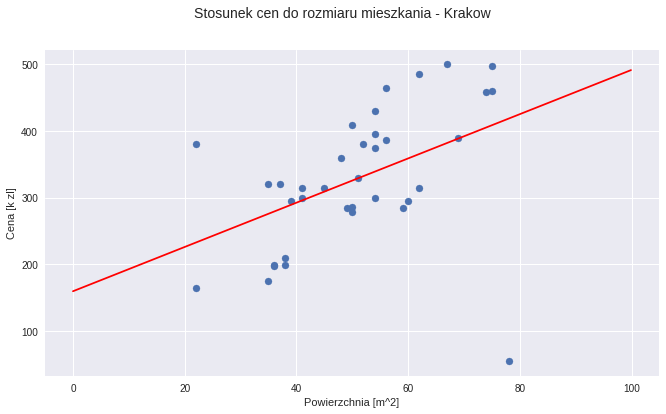

In [30]:
print("Parametry modelu po uczeniu: {}".format(parameters))

# Wizualizacja danych
fig = plt.figure(figsize=(11,6))
fig.suptitle("Stosunek cen do rozmiaru mieszkania - Krakow", fontsize=14)
plt.scatter(X[:,0], y);
plt.ylabel('Cena [k zl]')
plt.xlabel('Powierzchnia [m^2]');

value_space = np.arange(0, 100, 0.1).reshape(-1, 1)
predictions = model.predict(value_space)

plt.plot(np.arange(0, 100, 0.1), predictions, c="red");